# Running Model

Calibrated params from calibration_us_gdp.ipynb

In [1]:
# Import packages
from abm_funs import *
# from us_input import *
import numpy as np
from copy import deepcopy 
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import math as math
from copy import deepcopy
import os
import seaborn as sns
import datetime
from collate_macro_vars import *
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
import csv

rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/"

import os
print(os.cpu_count()) 

save = False

NEW Function import successful
8


In [2]:
#realgdp = macro_observations[["DATE", "REALGDP"]].dropna(subset=["REALGDP"]).reset_index()
realgdp['log_REALGDP'] = np.log2(realgdp['REALGDP'])

# GDP Filter
cycle, trend = hpfilter(realgdp['log_REALGDP'], lamb=129600)
 
# Adding the trend and cycle to the original DataFrame
realgdp['log_Trend'] = trend+1
realgdp['log_Cycle'] = cycle+1
realgdp['Trend'] = np.exp(trend)
realgdp['Cycle'] = np.exp(cycle)

realgdp_no_covid = realgdp[realgdp['DATE'] < "2019-10-1"].copy()
realgdp['scaled_log_Cycle'] = (realgdp['log_Cycle'] - realgdp['log_Cycle'].min()) / (realgdp['log_Cycle'].max() - realgdp['log_Cycle'].min())
realgdp_no_covid['scaled_log_Cycle'] = (realgdp_no_covid['log_Cycle'] - realgdp_no_covid['log_Cycle'].min()) / (realgdp_no_covid['log_Cycle'].max() - realgdp_no_covid['log_Cycle'].min())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

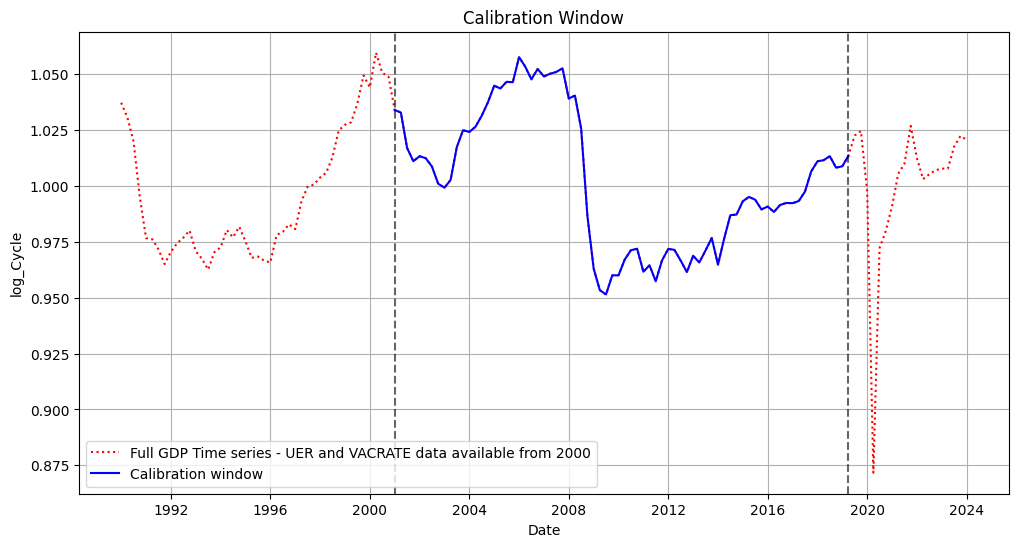

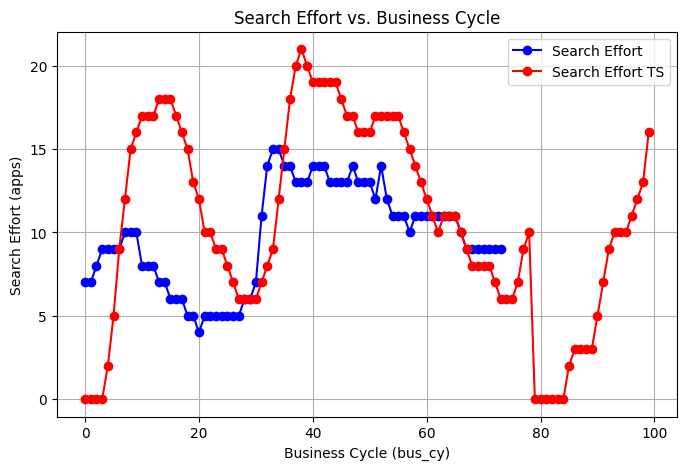

In [3]:
# Different calibration windoes
# Full time series: "2024-5-1"
# calib_date = ["2004-12-01", "2019-05-01"]
calib_date = ["2000-12-01", "2019-05-01"]
# calib_date = ["2000-12-01", "2024-05-01"]
gdp_dat_pd = realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]
gdp_dat = np.array(gdp_dat_pd['log_Cycle'])

# PLOTTING
plt.figure(figsize=(12, 6))

# Plot original data
sns.lineplot(data = realgdp, x = 'DATE', y = 'log_Cycle', color = "red", label = "Full GDP Time series - UER and VACRATE data available from 2000", linestyle = "dotted")
sns.lineplot(data=gdp_dat_pd, x='DATE', y='log_Cycle', color='blue', label='Calibration window')

# Plot synthetic data fluctuating around mean
#sns.lineplot(data=before_gdp_df, x='DATE', y='scaled_log_Cycle', color='red', linestyle='dashed', label='Before (Synthetic)')
#sns.lineplot(data=after_gdp_df, x='DATE', y='scaled_log_Cycle', color='red', linestyle='dashed', label='After (Synthetic)')
#sns.lineplot(data=extended_gdp_df, x='DATE', y='log_Cycle', color='red', linestyle='dashed', label='Full TS with Synthetic Data Extension')
#sns.lineplot(data = mean_gdp_cycle, x = 'DATE', y = 'VALUE', color = "purple", label = "Synthetic Stationary Data Around Mean")

# Mark original data boundaries
plt.axvline(x=gdp_dat_pd['DATE'].min(), color='black', linestyle='--', alpha=0.6)
plt.axvline(x=gdp_dat_pd['DATE'].max(), color='black', linestyle='--', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('log_Cycle')
plt.title('Calibration Window')
plt.legend()
plt.grid(True)
plt.show()



search_effort_dat = pd.read_csv("data/quarterly_search_ts.csv")
search_effort_dat['DATE'] = pd.to_datetime(search_effort_dat['year'].astype(str) + '-' + (search_effort_dat['quarter'] * 3 - 2).astype(str) + '-01')
search_effort_np = np.array(search_effort_dat['value_smooth'])
search_effort_np = search_effort_np/search_effort_np.mean()
#realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]

# Define a range of bus_cy values  # Generates 100 values from 0 to 1
search_effort_values = [search_effort(0, b) for b in gdp_dat]  # Apply function
# def search_effort_ts(t_unemp, se):
#     apps = max(0, round(10 - 100*(1-se)))
#     # if discouraged:
#     #     apps = round(a_stable/((t_unemp)**2 + 1)) + 1
#     return apps
search_effort_values_dyn = [search_effort_ts(0, b) for b in search_effort_np]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='b', label="Search Effort")
plt.plot(range(len(search_effort_values_dyn)), search_effort_values_dyn, marker='o', linestyle='-', color='r', label="Search Effort TS")
plt.xlabel("Business Cycle (bus_cy)")
plt.ylabel("Search Effort (apps)")
plt.title("Search Effort vs. Business Cycle")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Macro observations
observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset=["UNRATE", "VACRATE"]).reset_index()
# Load US_input data
A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
print(vac_rate_base)
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}

###################################
# Initialise the model
##################################
net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 3)


# observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()
# Load calibrated parameters from CSV
param_df = pd.read_csv("output_04_01/calibrated_params_all.csv")
# Sort by Timestamp in descending order
param_df = param_df.sort_values(by='Timestamp', ascending=False)

# Keep only the latest version of each parameter by removing duplicates
param_df = param_df.drop_duplicates(subset=['Parameter', 'Behav_Mode'], keep='first')
print(param_df)

final_params = {'mod_data': mod_data, 
            'net_temp': net_temp,
            'vacs': vacs, 
            'time_steps': len(gdp_dat),
            'delay': 0,
            'gdp_data': gdp_dat,
            'simple_res': False,
            'search_eff_ts': None}

# Define the plot size
final_params.update({'behav_spec': False})

# Create independent copies for non-behavioral and behavioral parameter sets
non_behav_params = deepcopy(final_params)
non_behav_params.update(
    param_df[param_df['Behav_Mode'] == False].set_index('Parameter')['Value'].to_dict()
)

sim_record_f, sim_net_f, sum_stats_f = run_single_local(**non_behav_params)

behav_params = deepcopy(final_params)
behav_params.update(
    param_df[param_df['Behav_Mode'] == True].set_index('Parameter')['Value'].to_dict()
)
behav_params.update({'behav_spec': True})  # Ensure correct behavior flag

behav_params_ts = deepcopy(final_params)
behav_params_ts.update(
    param_df[param_df['Behav_Mode'] == True].set_index('Parameter')['Value'].to_dict()
)
behav_params_ts.update({'behav_spec': True,
                     'search_eff_ts': search_effort_np}) 

0.029513888888888888
   Parameter     Value  Behav_Mode            Timestamp
51   gamma_v  0.149938        True  2025-04-01 19:57:53
50   gamma_u  0.800459        True  2025-04-01 19:57:53
49       d_v  0.021077        True  2025-04-01 19:57:53
48       d_u  0.014521        True  2025-04-01 19:57:53
47   gamma_v  0.353203       False  2025-04-01 19:49:10
46   gamma_u  0.478640       False  2025-04-01 19:49:10
45       d_v  0.015563       False  2025-04-01 19:49:10
44       d_u  0.028620       False  2025-04-01 19:49:10
False
False


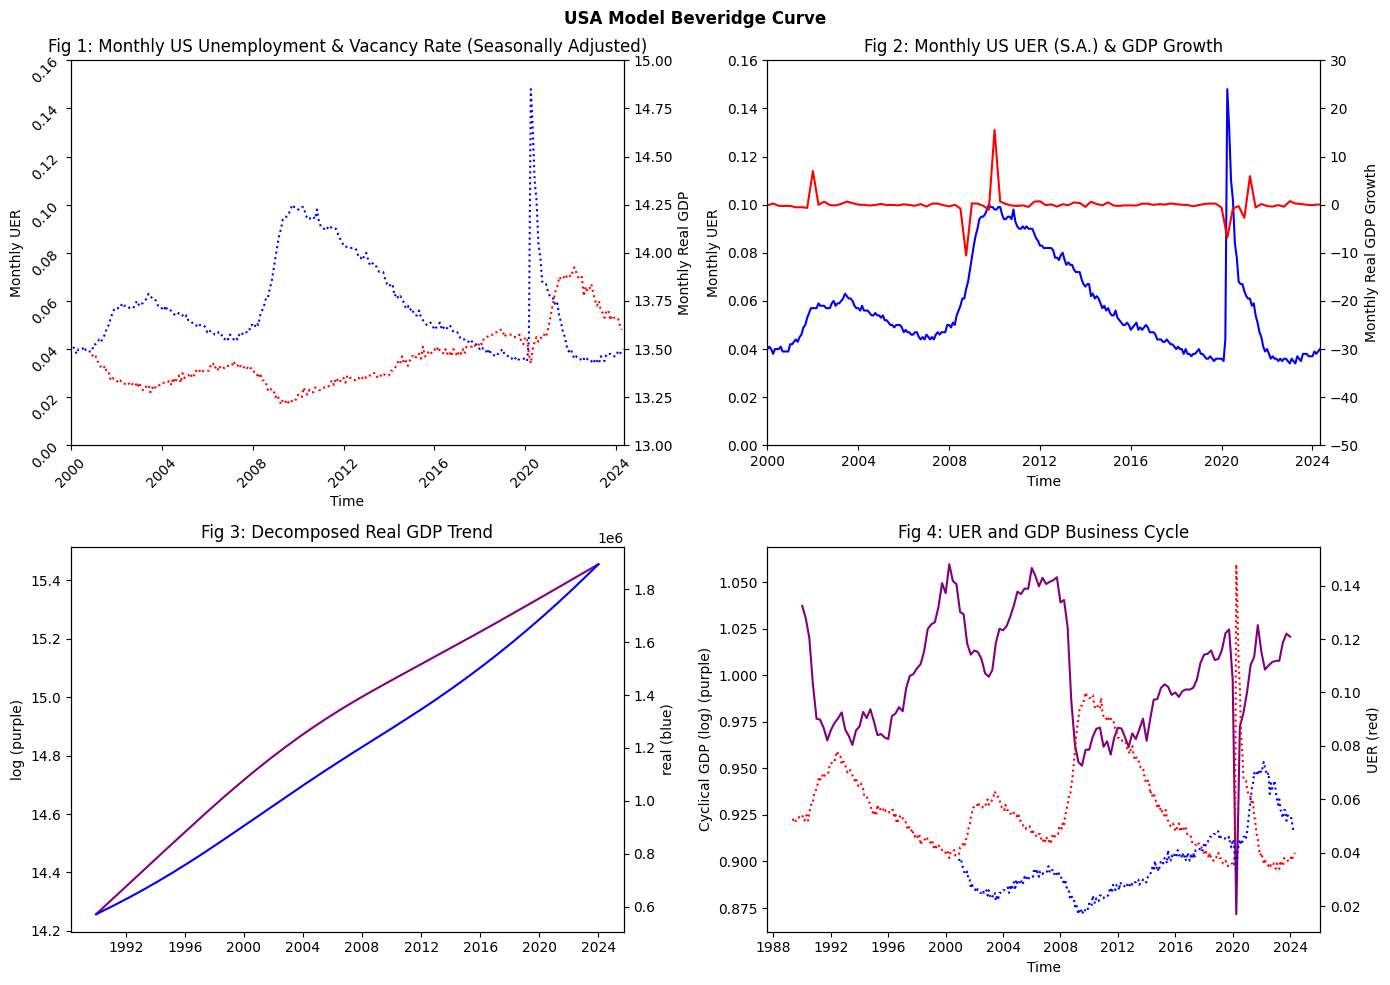

In [5]:

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

# Unpack the axes into variables for easier access
(ax1, ax2), (ax3, ax4) = axes


ax1.plot(macro_observations['DATE'], macro_observations['UER'], color = "blue", linestyle = "dotted")
ax1.plot(macro_observations['DATE'], macro_observations['VACRATE'], color = "red", linestyle = "dotted")
# recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax1.set_title("Fig 1: Monthly US Unemployment & Vacancy Rate (Seasonally Adjusted)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Monthly UER")
ax1_twin = ax1.twinx()
ax1_twin.set_ylim([13, 15])
ax1.tick_params(rotation=45)
ax1.set_xlim([datetime.date(2000,1,1), datetime.date(2024,5,1)])
ax1.set_ylim([0, 0.16])
ax1_twin.set_ylabel("Monthly Real GDP")

ax2.plot(macro_observations['DATE'], macro_observations['UER'], color = "blue")
ax2_twin = ax2.twinx()
ax2_twin.plot(gdp_growth['DATE'], gdp_growth['GDP_GROWTH'].pct_change(periods = 1), label = "Real GDP", color = "red")

# recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax2.set_title("Fig 2: Monthly US UER (S.A.) & GDP Growth")
ax2.set_xlabel("Time")
ax2.set_ylabel("Monthly UER")
ax2.set_xlim([datetime.date(2000,1,1), datetime.date(2024,5,1)])
ax2.set_ylim([0, 0.16])
ax2_twin.set_ylim([-50, 30])
ax2_twin.set_ylabel("Monthly Real GDP Growth")

ax3.plot(realgdp['DATE'], realgdp['log_Trend'], color = "purple")
ax3_twin = ax3.twinx()
ax3_twin.plot(realgdp['DATE'], realgdp['Trend'], color = "blue")
ax3.set_title("Fig 3: Decomposed Real GDP Trend")
ax3.set_ylabel("log (purple)")
ax3_twin.set_ylabel("real (blue)")

ax4.plot(realgdp['DATE'], realgdp['log_Cycle'], color = "purple")
ax4_twin = ax4.twinx()
ax4_twin.plot(macro_observations['DATE'], macro_observations['UER'], color = "red", linestyle = "dotted")
ax4_twin.plot(macro_observations['DATE'], macro_observations['VACRATE'], color = "blue", linestyle = "dotted")
ax4.set_title("Fig 4: Decomposed Real GDP Cycle")
ax4.set_ylabel("Cyclical GDP (log) (purple)")
#ax4.set_xlim([datetime.date(2000,1,1), datetime.date(2019,10,1)])

ax4_twin.set_ylabel("UER (red)")

# recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax4.set_title("Fig 4: UER and GDP Business Cycle")
ax4.set_xlabel("Time")
#ax4.set_xlim([datetime.date(2000,1,1), datetime.date(2024,5,1)])

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()


#plt.savefig('../output/usa/beveridge_behav_0_1_all.jpg', dpi = 300)
plt.show()
plt.close()


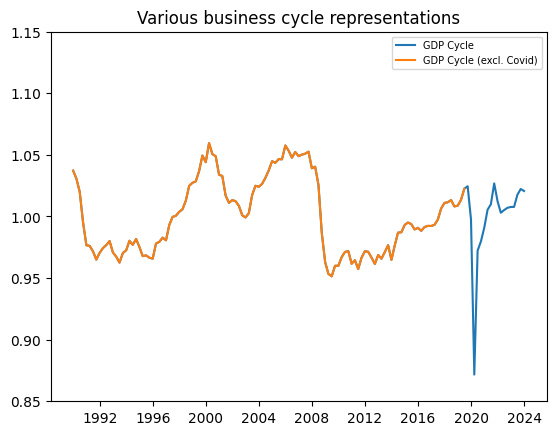

In [6]:
t = np.arange(0,len(realgdp['DATE']),1)
#bus_cycle = bus_cycle_demand(0.5, t, 1, 30)

#plt.plot(realgdp['DATE'], bus_cycle, label = "Stylised Sinusoidal Business Cycle")
plt.plot(realgdp['DATE'], realgdp['log_Cycle'], label = "GDP Cycle")
plt.plot(realgdp_no_covid['DATE'], realgdp_no_covid['log_Cycle'], label = "GDP Cycle (excl. Covid)")
#plt.plot(np.arange(0,78,1), gdp_dat, label = "Calib Period" )
plt.legend(fontsize=7)
plt.ylim([0.85,1.15])
plt.title("Various business cycle representations")

plt.show()

# Save to CSV
#realgdp_no_covid.to_csv('detrended_gdp_nocovid.csv', index=False)
# Save to CSV
#realgdp.to_csv('detrended_gdp.csv', index=False)

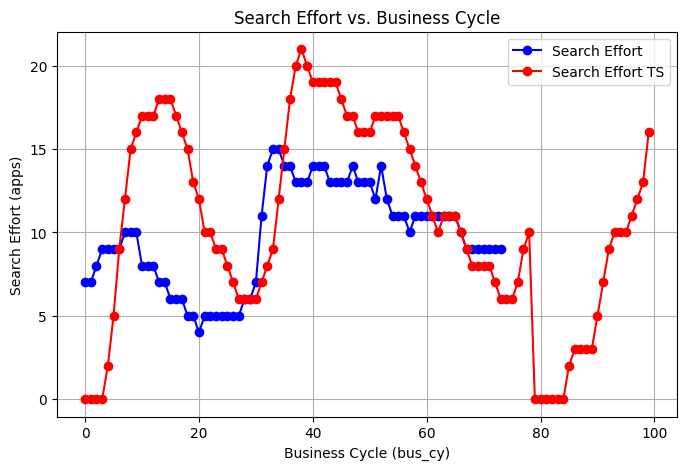

In [7]:
search_effort_dat = pd.read_csv("data/quarterly_search_ts.csv")
search_effort_dat['DATE'] = pd.to_datetime(search_effort_dat['year'].astype(str) + '-' + (search_effort_dat['quarter'] * 3 - 2).astype(str) + '-01')
search_effort_np = np.array(search_effort_dat['value_smooth'])
search_effort_np = search_effort_np/search_effort_np.mean()
#realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]

# Define a range of bus_cy values  # Generates 100 values from 0 to 1
search_effort_values = [search_effort(0, b) for b in gdp_dat]  # Apply function
# def search_effort_ts(t_unemp, se):
#     apps = max(0, round(10 - 100*(1-se)))
#     # if discouraged:
#     #     apps = round(a_stable/((t_unemp)**2 + 1)) + 1
#     return apps
search_effort_values_dyn = [search_effort_ts(0, b) for b in search_effort_np]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='b', label="Search Effort")
plt.plot(range(len(search_effort_values_dyn)), search_effort_values_dyn, marker='o', linestyle='-', color='r', label="Search Effort TS")
plt.xlabel("Business Cycle (bus_cy)")
plt.ylabel("Search Effort (apps)")
plt.title("Search Effort vs. Business Cycle")
plt.legend()
plt.grid(True)
plt.show()


True
True


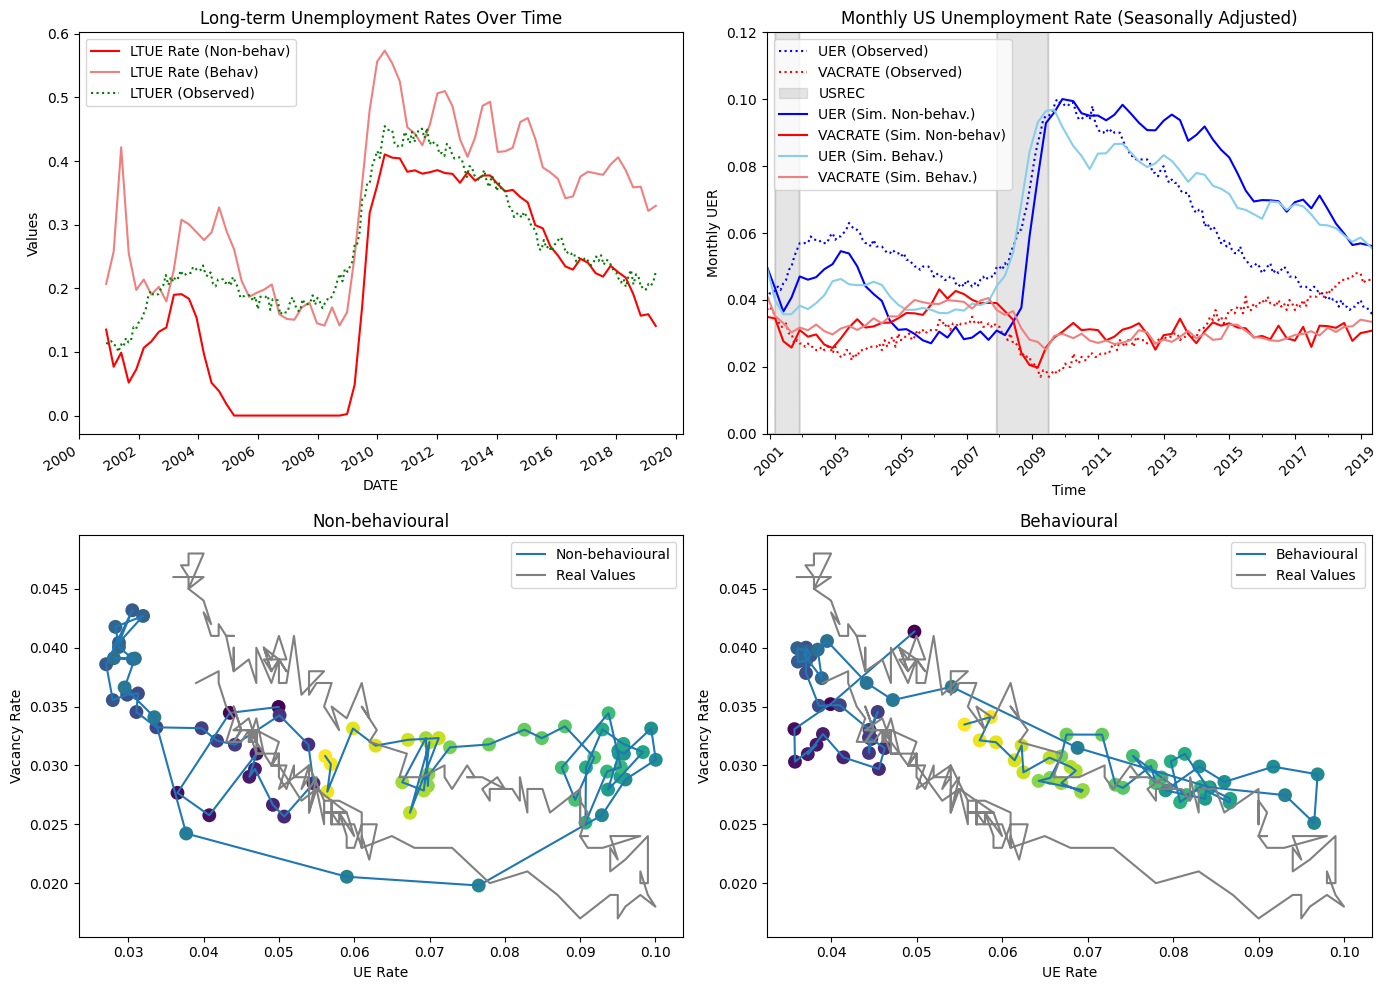

In [8]:
# Run the model for behavioral case
sim_record_t, sim_net_t, sum_stats_t = run_single_local(**behav_params)
# Summary values for one run 
# sim_record_t = pd.DataFrame(np.transpose(np.hstack(sim_record_t_all)))
sim_record_t = pd.DataFrame(sim_record_t)
sim_record_t.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Current Demand', 'Target_Demand', 'Created_Vacs']
# sim_record_f = pd.DataFrame(np.transpose(np.hstack(sim_record_f_all)))
sim_record_f = pd.DataFrame(sim_record_f)
sim_record_f.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Current Demand', 'Target_Demand', 'Created_Vacs']

record1_t = sim_record_t.groupby(['Time Step']).sum().reset_index()  
record1_f = sim_record_f.groupby(['Time Step']).sum().reset_index()

ue_vac_f = record1_f.loc[:,['Workers', 'Unemployment', 'LT Unemployed Persons', 'Current Demand', 'Vacancies', 'Target_Demand', 'Created_Vacs']]
ue_vac_f['UE Rate'] = ue_vac_f['Unemployment'] / ue_vac_f['Workers']
ue_vac_f['Vac Rate'] = ue_vac_f['Vacancies'] / ue_vac_f['Target_Demand']
ue_vac_f['LTUE Rate'] = ue_vac_f['LT Unemployed Persons'] / ue_vac_f['Unemployment']
ue_vac_f['PROV DATE'] = pd.date_range(start=calib_date[0], end=calib_date[1], periods=len(sim_record_f))

ue_vac_t = record1_t.loc[:,['Workers', 'Unemployment', 'LT Unemployed Persons', 'Current Demand', 'Vacancies', 'Target_Demand', 'Created_Vacs']]
ue_vac_t['UE Rate'] = ue_vac_t['Unemployment'] / ue_vac_t['Workers']
ue_vac_t['Vac Rate'] = ue_vac_t['Vacancies'] / ue_vac_t['Target_Demand']
ue_vac_t['LTUE Rate'] = ue_vac_t['LT Unemployed Persons'] / ue_vac_t['Unemployment']
ue_vac_t['PROV DATE'] = pd.date_range(start=calib_date[0], end=calib_date[1], periods=len(sim_record_t))

# Create a figure with a 1-row, 3-column layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 3 rows, 1 column

### **First Plot: Unemployment, LT Unemployed Persons, and Vacancies Over Time**
#axes[0,0].plot(ue_vac_f['PROV DATE'], ue_vac_f['UE Rate'], label="UE Rate (Non-behav)", color = "blue")
axes[0,0].plot(ue_vac_f['PROV DATE'], ue_vac_f['LTUE Rate'], label="LTUE Rate (Non-behav)", color = "red")
#axes[0,0].plot(ue_vac_t['PROV DATE'], ue_vac_t['UE Rate'], label="UE Rate (Behav)", color = "skyblue")
axes[0,0].plot(ue_vac_t['PROV DATE'], ue_vac_t['LTUE Rate'], label="LTUE Rate (Behav)", color = "lightcoral")
macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index().plot.line(ax=axes[0,0], x='DATE', y='LTUER', color="green", linestyle="dotted", label="LTUER (Observed)")

axes[0,0].set_xlabel('DATE')
axes[0,0].set_ylabel('Values')
axes[0,0].set_title('Long-term Unemployment Rates Over Time')
axes[0,0].legend()

### **Second Plot: USA Model Beveridge Curve (Non-behavioural vs Behavioural)**
axes[1,0].plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], label="Non-behavioural")
axes[1,0].scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f.index, s=100, lw=0)
axes[1,0].plot(observation['UER'], observation['VACRATE'], label = "Real Values", color = "grey")
#axes[1,0].scatter(observation['UER'], observation['VACRATE'], lw = 0, color = "lightgrey")
axes[1,0].set_title("Non-behavioural")
axes[1,0].set_xlabel("UE Rate")
axes[1,0].set_ylabel("Vacancy Rate")
axes[1,0].legend()

axes[1,1].plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], label="Behavioural")
axes[1,1].scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t.index, s=100, lw=0)
axes[1,1].plot(observation['UER'], observation['VACRATE'], label = "Real Values", color = "grey")
#axes[1,1].scatter(observation['UER'], observation['VACRATE'], lw = 0, color = "lightgrey")
axes[1,1].set_title("Behavioural")
axes[1,1].set_xlabel("UE Rate")
axes[1,1].set_ylabel("Vacancy Rate")
axes[1,1].legend()

### **Third Plot: Monthly US Unemployment Rate (Seasonally Adjusted)**
macro_observations.plot.line(ax=axes[0,1], x='DATE', y='UER', color="blue", linestyle="dotted", label="UER (Observed)")
macro_observations.plot.line(ax=axes[0,1], x='DATE', y='VACRATE', color="red", linestyle="dotted", label="VACRATE (Observed)")
recessions.plot.area(ax=axes[0,1], x='DATE', color="grey", alpha=0.2)
ue_vac_f.plot.line(ax=axes[0,1], x='PROV DATE', y='UE Rate', color="blue", label="UER (Sim. Non-behav.)")
ue_vac_f.plot.line(ax=axes[0,1], x='PROV DATE', y='Vac Rate', color="red", label="VACRATE (Sim. Non-behav)")
ue_vac_t.plot.line(ax=axes[0,1], x='PROV DATE', y='UE Rate', color="skyblue", label="UER (Sim. Behav.)")
ue_vac_t.plot.line(ax=axes[0,1], x='PROV DATE', y='Vac Rate', color="lightcoral", label="VACRATE (Sim. Behav.)")

axes[0,1].set_xlim(calib_date[0], calib_date[1])
axes[0,1].set_ylim(0, 0.12)
axes[0,1].set_title('Monthly US Unemployment Rate (Seasonally Adjusted)')
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('Monthly UER')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

if save:
    plt.savefig(f"results_bev_ltuer_uer_vac_plots.png", dpi = 300)
    plt.close()
# Show the final figure with all 3 subplots
else: 
    plt.show()

In [9]:
# Run the model for behavioral case
print(behav_params['gamma_v'])
print(behav_params['d_v'])
testing = deepcopy(behav_params)
testing.update({'gamma_v': 0.5})
testing.update({'d_v': 0.009})
print(testing['gamma_v'])

# testing different gamma_vs here instead....
sim_record_t_ts, sim_net_t_ts, sum_stats_t_ts = run_single_local(**testing)
sim_record_t_ts = pd.DataFrame(sim_record_t_ts)
sim_record_t_ts.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Current Demand', 'Target_Demand', 'Created_Vacs']

record1_t_ts = sim_record_t_ts.groupby(['Time Step']).sum().reset_index()  

ue_vac_t_ts = record1_t_ts.loc[:,['Workers', 'Unemployment', 'LT Unemployed Persons', 'Vacancies', 'Target_Demand', 'Created_Vacs']]
ue_vac_t_ts['UE Rate'] = ue_vac_t_ts['Unemployment'] / ue_vac_t_ts['Workers']
ue_vac_t_ts['Vac Rate'] = ue_vac_t_ts['Vacancies'] / ue_vac_t_ts['Target_Demand']
ue_vac_t_ts['LTUE Rate'] = ue_vac_t_ts['LT Unemployed Persons'] / ue_vac_t_ts['Unemployment']
ue_vac_t_ts['PROV DATE'] = pd.date_range(start=calib_date[0], end=calib_date[1], periods=len(sim_record_t_ts))



0.1499380150315576
0.021077399273907
0.5
True
True


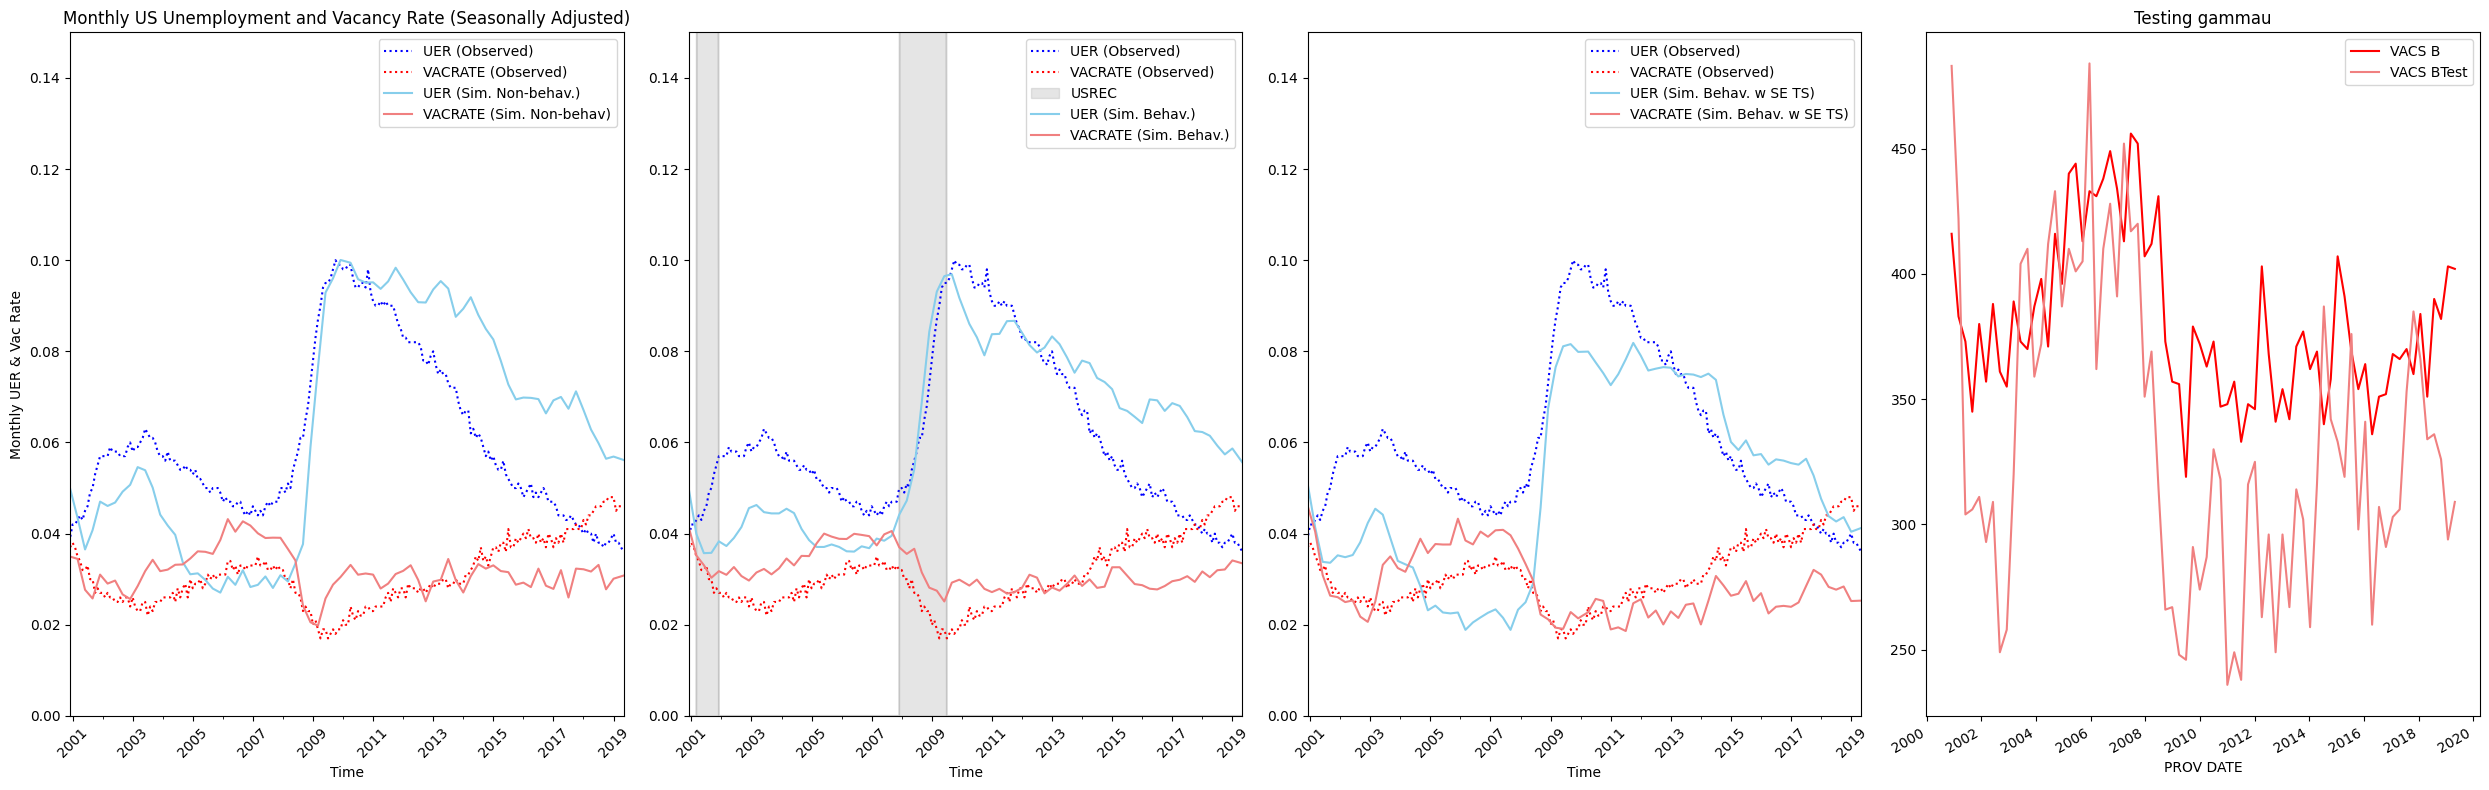

In [10]:
# Create a figure with a 1-row, 3-column layout
fig, axes = plt.subplots(1,4,figsize=(25, 8))  # 3 rows, 1 column

### **Third Plot: Monthly US Unemployment Rate (Seasonally Adjusted)**
macro_observations.plot.line(ax=axes[0], x='DATE', y='UER', color="blue", linestyle="dotted", label="UER (Observed)")
macro_observations.plot.line(ax=axes[1], x='DATE', y='UER', color="blue", linestyle="dotted", label="UER (Observed)")
macro_observations.plot.line(ax=axes[2], x='DATE', y='UER', color="blue", linestyle="dotted", label="UER (Observed)")
macro_observations.plot.line(ax=axes[0], x='DATE', y='VACRATE', color="red", linestyle="dotted", label="VACRATE (Observed)")
macro_observations.plot.line(ax=axes[1], x='DATE', y='VACRATE', color="red", linestyle="dotted", label="VACRATE (Observed)")
macro_observations.plot.line(ax=axes[2], x='DATE', y='VACRATE', color="red", linestyle="dotted", label="VACRATE (Observed)")
recessions.plot.area(ax=axes[1], x='DATE', color="grey", alpha=0.2)
ue_vac_f.plot.line(ax=axes[0], x='PROV DATE', y='UE Rate', color="skyblue", label="UER (Sim. Non-behav.)")
ue_vac_f.plot.line(ax=axes[0], x='PROV DATE', y='Vac Rate', color="lightcoral", label="VACRATE (Sim. Non-behav)")
ue_vac_t.plot.line(ax=axes[1], x='PROV DATE', y='UE Rate', color="skyblue", label="UER (Sim. Behav.)")
ue_vac_t.plot.line(ax=axes[1], x='PROV DATE', y='Vac Rate', color="lightcoral", label="VACRATE (Sim. Behav.)")
ue_vac_t_ts.plot.line(ax=axes[2], x='PROV DATE', y='UE Rate', color="skyblue", label="UER (Sim. Behav. w SE TS)")
ue_vac_t_ts.plot.line(ax=axes[2], x='PROV DATE', y='Vac Rate', color="lightcoral", label="VACRATE (Sim. Behav. w SE TS)")


#ue_vac_f.plot(ax=axes[3], x='PROV DATE', y = 'Created_Vacs', label="VACS NB", color = "blue")
ue_vac_t.plot(ax=axes[3], x='PROV DATE', y = 'Created_Vacs', label="VACS B", color = "red")
ue_vac_t_ts.plot(ax=axes[3], x='PROV DATE', y = 'Created_Vacs', label="VACS BTest", color = "lightcoral")
axes[3].set_title("Testing gammau")
# axes2[0].set_ylim(0.015, 0.055)
# axes2[0].set_xlim(0.03, 0.125)
axes[3].legend()

axes[0].set_xlim(calib_date[0], calib_date[1])
axes[1].set_xlim(calib_date[0], calib_date[1])
axes[2].set_xlim(calib_date[0], calib_date[1])
axes[0].set_ylim(0, 0.15)
axes[1].set_ylim(0, 0.15)
axes[2].set_ylim(0, 0.15)
axes[0].set_title('Monthly US Unemployment and Vacancy Rate (Seasonally Adjusted)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Monthly UER & Vac Rate')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[1].set_xlabel('Time')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[2].set_xlabel('Time')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend()


# Adjust layout to prevent overlap
plt.tight_layout()

if save:
    plt.savefig(f"results_comp.png", dpi = 300)
    plt.close()
# Show the final figure with all 3 subplots
else: 
    plt.show()

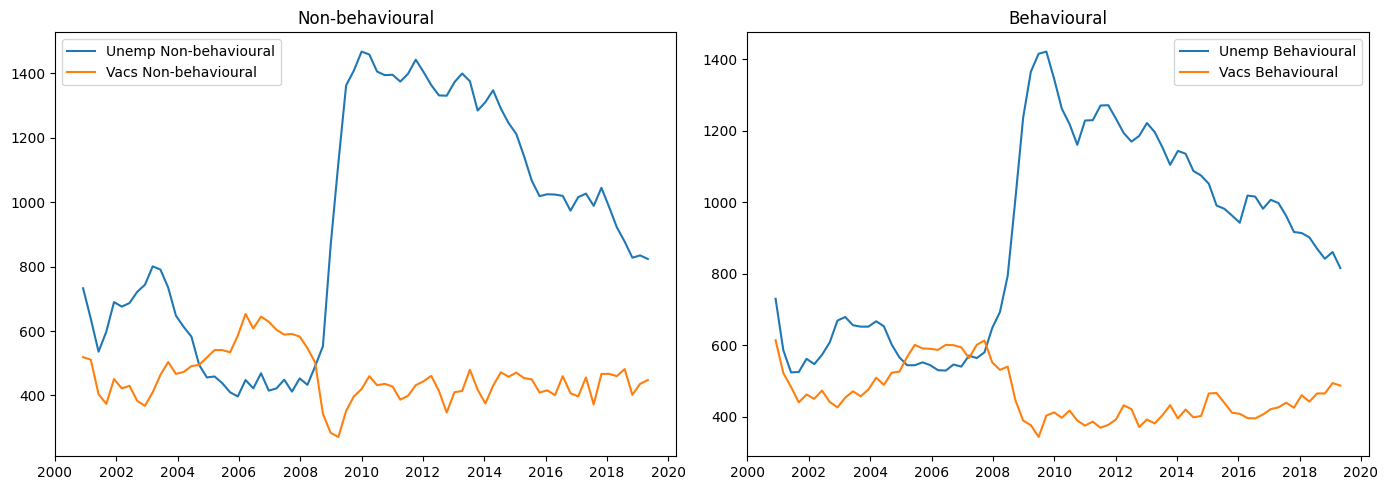

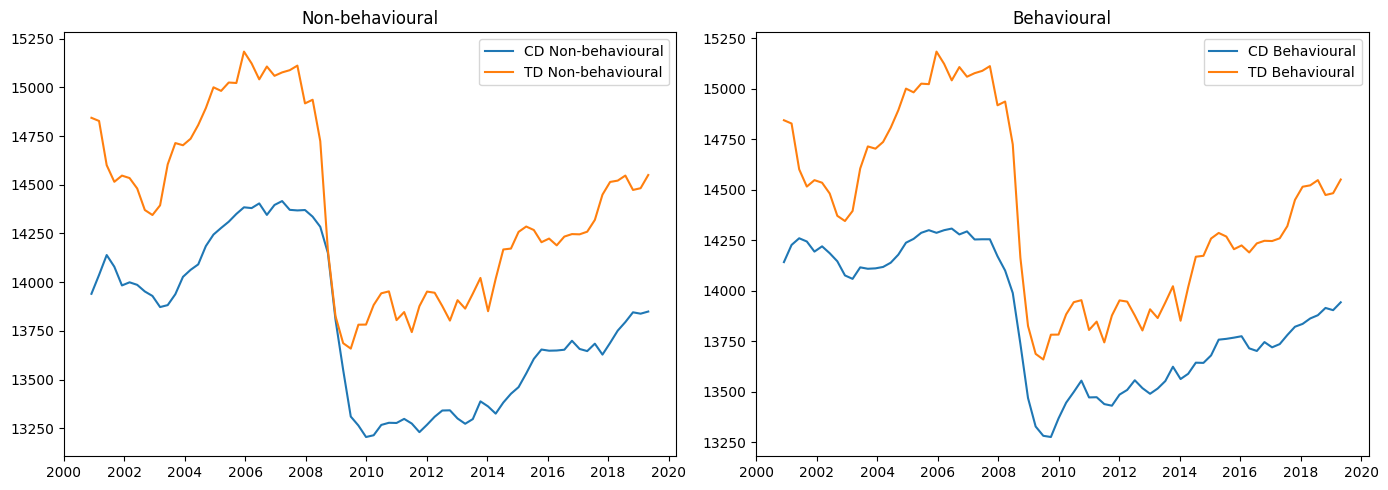

In [11]:
# --- Second Figure: Bottom Two Subplots ---
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Third Plot (Bottom-Left: Non-behavioural Beveridge Curve)
#axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Employment'], label="Emp Non-behavioural")
axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Unemployment'], label="Unemp Non-behavioural")
axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Vacancies'], label="Vacs Non-behavioural")
axes2[0].set_title("Non-behavioural")
# axes2[0].set_ylim(0.015, 0.055)
# axes2[0].set_xlim(0.03, 0.125)
axes2[0].legend()

# Fourth Plot (Bottom-Right: Behavioural Beveridge Curve)
# Third Plot (Bottom-Left: Non-behavioural Beveridge Curve)
#axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Employment'], label="Emp Behavioural")
axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Unemployment'], label="Unemp Behavioural")
axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Vacancies'], label="Vacs Behavioural")
axes2[1].set_title("Behavioural")
# axes2[1].set_ylim(0.015, 0.055)
# axes2[1].set_xlim(0.03, 0.125)
axes2[1].legend()

plt.tight_layout()
# Save the figure to the output folder
if save:
    plt.savefig(f"bev_curves.png", dpi=300)
    plt.close()  # Close figure to free memory
else:
    plt.show()

# --- Second Figure: Bottom Two Subplots ---
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Third Plot (Bottom-Left: Non-behavioural Beveridge Curve)
#axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Employment'], label="Emp Non-behavioural")
axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Current Demand'], label="CD Non-behavioural")
axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Target_Demand'], label="TD Non-behavioural")
axes2[0].set_title("Non-behavioural")
# axes2[0].set_ylim(0.015, 0.055)
# axes2[0].set_xlim(0.03, 0.125)
axes2[0].legend()

# Fourth Plot (Bottom-Right: Behavioural Beveridge Curve)
# Third Plot (Bottom-Left: Non-behavioural Beveridge Curve)
#axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Employment'], label="Emp Behavioural")
axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Current Demand'], label="CD Behavioural")
axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Target_Demand'], label="TD Behavioural")
axes2[1].set_title("Behavioural")
# axes2[1].set_ylim(0.015, 0.055)
# axes2[1].set_xlim(0.03, 0.125)
axes2[1].legend()

plt.tight_layout()
# Save the figure to the output folder
if save:
    plt.savefig(f"bev_curves.png", dpi=300)
    plt.close()  # Close figure to free memory
else:
    plt.show()

